# Phase 2: Data Cleaning

**Objectives:**
1. Handle missing values
2. Remove duplicates
3. Handle outliers (Price + Duration)
4. Feature engineering
5. Data type corrections
6. Save cleaned data

## 2.1 Import Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

## 2.2 Load Data

In [41]:
# Load data
df = pd.read_excel('D:/Courses/DL INTERNSHIP/SECOND PROJECT/project_structure/data/raw/Data_Train.xlsx')
print(f"Original shape: {df.shape}")

Original shape: (10683, 11)


In [42]:
# Store original count for tracking
original_rows = len(df)
cleaning_log = {'Original': original_rows}

---
## 2.3 Handle Missing Values

In [43]:
# Check missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df[missing_df['Missing'] > 0]

,Missing,Percentage
Route,1,0.01
Total_Stops,1,0.01


In [44]:
# Drop rows with missing values (< 5% rule)
df = df.dropna()
cleaning_log['After Missing Removal'] = len(df)
print(f"Rows after removing missing values: {len(df)}")
print(f"Removed: {cleaning_log['Original'] - len(df)} rows")

Rows after removing missing values: 10682
Removed: 1 rows


---
## 2.4 Remove Duplicates

In [45]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 220


In [46]:
# Remove duplicates
df = df.drop_duplicates()
cleaning_log['After Duplicate Removal'] = len(df)
print(f"Rows after removing duplicates: {len(df)}")
print(f"Removed: {cleaning_log['After Missing Removal'] - len(df)} rows")

Rows after removing duplicates: 10462
Removed: 220 rows


---
## 2.5 Feature Engineering (Before Outlier Detection)

We need to engineer features first to detect duration outliers properly.

### 2.5.1 Parse Duration

In [47]:
def parse_duration(duration_str):
    """Convert duration string to minutes."""
    total_minutes = 0
    duration_str = str(duration_str).strip()
    
    if 'h' in duration_str:
        parts = duration_str.split('h')
        hours = int(parts[0].strip())
        total_minutes += hours * 60
        
        if len(parts) > 1 and 'm' in parts[1]:
            minutes = int(parts[1].replace('m', '').strip())
            total_minutes += minutes
    elif 'm' in duration_str:
        total_minutes = int(duration_str.replace('m', '').strip())
    
    return total_minutes

df['Duration_Minutes'] = df['Duration'].apply(parse_duration)
print("Duration parsed to minutes")
print(df['Duration_Minutes'].describe())

Duration parsed to minutes
count    10462.000000
mean       629.781591
std        500.699045
min          5.000000
25%        170.000000
50%        505.000000
75%        910.000000
max       2860.000000
Name: Duration_Minutes, dtype: float64


### 2.5.2 Parse Total Stops

In [48]:
def parse_stops(stops_str):
    """Convert stops string to integer."""
    stops_str = str(stops_str).lower().strip()
    
    if 'non-stop' in stops_str:
        return 0
    elif 'stop' in stops_str:
        return int(stops_str.split()[0])
    else:
        return int(stops_str)

df['Stops'] = df['Total_Stops'].apply(parse_stops)
print("Stops parsed")
print(df['Stops'].value_counts().sort_index())

Stops parsed
Stops
0    3475
1    5625
2    1318
3      43
4       1
Name: count, dtype: int64


---
## 2.6 Handle Outliers

### 2.6.1 Price Outliers (IQR Method)

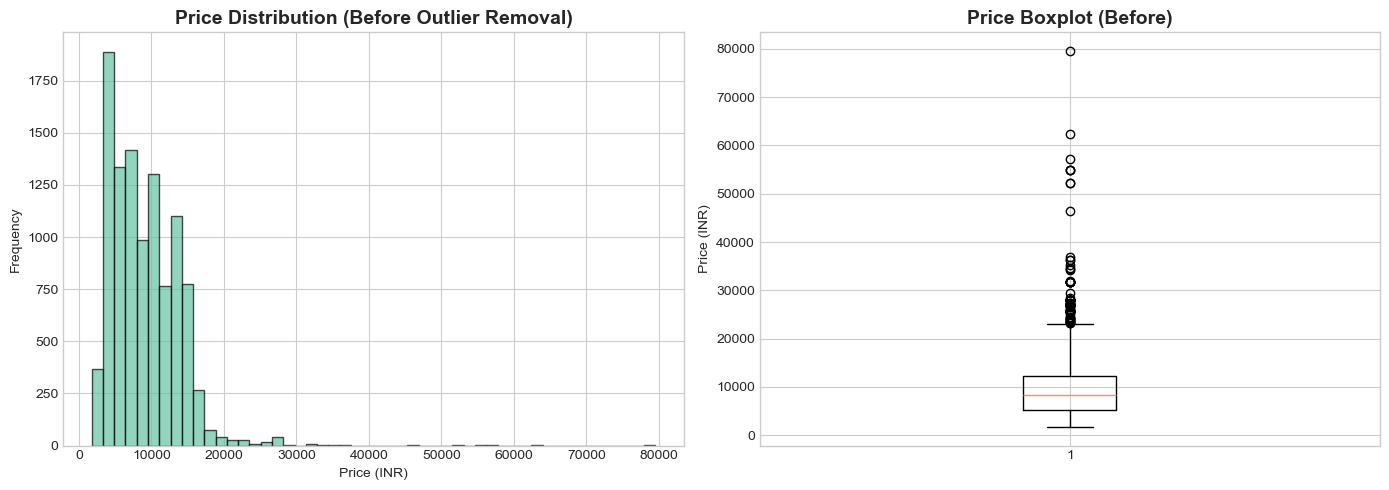

In [49]:
# Visualize price distribution before
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(df['Price'], bins=50, edgecolor='black', alpha=0.7)
ax.set_title('Price Distribution (Before Outlier Removal)', fontsize=14, fontweight='bold')
ax.set_xlabel('Price (INR)')
ax.set_ylabel('Frequency')

ax = axes[1]
ax.boxplot(df['Price'], vert=True)
ax.set_title('Price Boxplot (Before)', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (INR)')

plt.tight_layout()
plt.show()

In [50]:
# IQR method for Price
Q1_price = df['Price'].quantile(0.25)
Q3_price = df['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

print("Price Outlier Detection (IQR Method):")
print(f"  Q1: ₹{Q1_price:,.0f}")
print(f"  Q3: ₹{Q3_price:,.0f}")
print(f"  IQR: ₹{IQR_price:,.0f}")
print(f"  Lower Bound: ₹{lower_bound_price:,.0f}")
print(f"  Upper Bound: ₹{upper_bound_price:,.0f}")

# Count outliers
price_outliers_lower = (df['Price'] < lower_bound_price).sum()
price_outliers_upper = (df['Price'] > upper_bound_price).sum()
print(f"\n  Lower outliers: {price_outliers_lower}")
print(f"  Upper outliers: {price_outliers_upper}")
print(f"  Total price outliers: {price_outliers_lower + price_outliers_upper}")

Price Outlier Detection (IQR Method):
  Q1: ₹5,224
  Q3: ₹12,345
  IQR: ₹7,121
  Lower Bound: ₹-5,457
  Upper Bound: ₹23,026

  Lower outliers: 0
  Upper outliers: 94
  Total price outliers: 94


In [51]:
# Remove price outliers
df = df[(df['Price'] >= lower_bound_price) & (df['Price'] <= upper_bound_price)]
cleaning_log['After Price Outliers'] = len(df)
print(f"Rows after removing price outliers: {len(df)}")
print(f"Removed: {cleaning_log['After Duplicate Removal'] - len(df)} rows")

Rows after removing price outliers: 10368
Removed: 94 rows


### 2.6.2 Duration Outliers for Connecting Flights (NEW)

In [52]:
# Check duration stats by stops
print("Duration Statistics by Number of Stops:")
print("="*60)
duration_by_stops = df.groupby('Stops')['Duration_Minutes'].agg(['min', 'max', 'mean', 'median', 'count'])
duration_by_stops

Duration Statistics by Number of Stops:


,min,max,mean,median,count
Stops,,,,,
0,75,230,149.981279,160.0,3472
1,195,1750,782.490090,705.0,5550
2,5,2860,1217.791859,1245.0,1302
3,565,2280,1513.372093,1585.0,43
4,1770,1770,1770.000000,1770.0,1


In [53]:
# Investigate suspicious short durations for connecting flights
with_stops = df[df['Stops'] > 0]

print("\nInvestigating SHORT duration connecting flights:")
print("="*60)

# Flights with stops but very short duration (< 2 hours)
suspicious = with_stops[with_stops['Duration_Minutes'] < 120]
print(f"\nConnecting flights with duration < 120 min (2 hours): {len(suspicious)}")

if len(suspicious) > 0:
    print("\nSuspicious records:")
    print(suspicious[['Airline', 'Source', 'Destination', 'Stops', 'Duration_Minutes', 'Duration', 'Price']])


Investigating SHORT duration connecting flights:

Connecting flights with duration < 120 min (2 hours): 1

Suspicious records:
        Airline  Source Destination  Stops  Duration_Minutes Duration  Price
6474  Air India  Mumbai   Hyderabad      2                 5       5m  17327


In [54]:
# Define minimum realistic duration based on number of stops
# Reasoning:
# - 1 stop: At least 2 hours (flight + layover + flight)
# - 2 stops: At least 4 hours
# - 3 stops: At least 6 hours
# - 4 stops: At least 8 hours

MIN_DURATION_BY_STOPS = {
    0: 30,    # Non-stop: minimum 30 min (short domestic)
    1: 120,   # 1 stop: minimum 2 hours
    2: 240,   # 2 stops: minimum 4 hours
    3: 360,   # 3 stops: minimum 6 hours
    4: 480    # 4 stops: minimum 8 hours
}

print("Minimum Duration Thresholds:")
for stops, min_dur in MIN_DURATION_BY_STOPS.items():
    print(f"  {stops} stops: {min_dur} min ({min_dur/60:.1f} hours)")

Minimum Duration Thresholds:
  0 stops: 30 min (0.5 hours)
  1 stops: 120 min (2.0 hours)
  2 stops: 240 min (4.0 hours)
  3 stops: 360 min (6.0 hours)
  4 stops: 480 min (8.0 hours)


In [55]:
# Identify duration outliers
def is_valid_duration(row):
    """Check if duration is realistic for the number of stops."""
    min_duration = MIN_DURATION_BY_STOPS.get(row['Stops'], 30)
    return row['Duration_Minutes'] >= min_duration

# Flag invalid durations
df['Valid_Duration'] = df.apply(is_valid_duration, axis=1)

# Count invalid by stops
invalid_by_stops = df[~df['Valid_Duration']].groupby('Stops').size()
print("\nInvalid Duration Counts by Stops:")
print(invalid_by_stops)


Invalid Duration Counts by Stops:
Stops
2    3
dtype: int64


In [56]:
# Show all invalid duration records
invalid_records = df[~df['Valid_Duration']]
print(f"\nTotal invalid duration records: {len(invalid_records)}")

if len(invalid_records) > 0:
    print("\nInvalid records to be removed:")
    print(invalid_records[['Airline', 'Source', 'Destination', 'Stops', 'Duration_Minutes', 'Duration', 'Price']])


Total invalid duration records: 3

Invalid records to be removed:
        Airline  Source Destination  Stops  Duration_Minutes Duration  Price
6474  Air India  Mumbai   Hyderabad      2                 5       5m  17327
8232  Air India  Mumbai   Hyderabad      2               150   2h 30m  11972
8478  Air India  Mumbai   Hyderabad      2               205   3h 25m  18797


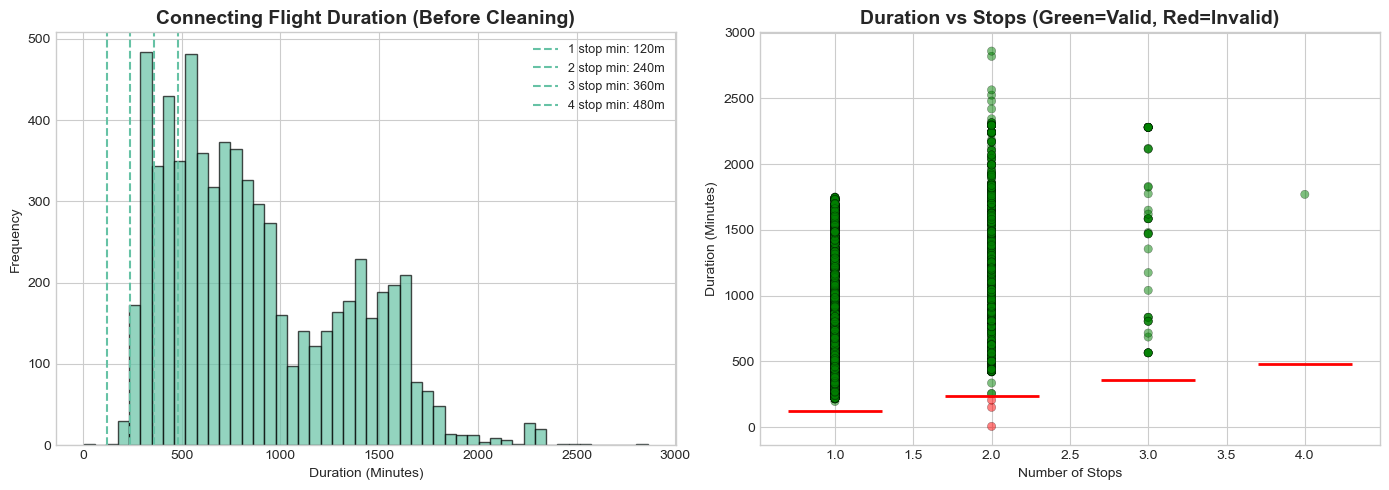

In [57]:
# Visualize before removing duration outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Connecting flights only
connecting = df[df['Stops'] > 0]

ax = axes[0]
ax.hist(connecting['Duration_Minutes'], bins=50, edgecolor='black', alpha=0.7)
for stops, min_dur in MIN_DURATION_BY_STOPS.items():
    if stops > 0:
        ax.axvline(min_dur, linestyle='--', linewidth=1.5, 
                   label=f'{stops} stop min: {min_dur}m')
ax.set_title('Connecting Flight Duration (Before Cleaning)', fontsize=14, fontweight='bold')
ax.set_xlabel('Duration (Minutes)')
ax.set_ylabel('Frequency')
ax.legend(fontsize=9)

ax = axes[1]
colors = ['green' if v else 'red' for v in connecting['Valid_Duration']]
ax.scatter(connecting['Stops'], connecting['Duration_Minutes'], c=colors, alpha=0.5, edgecolors='black', linewidth=0.3)
ax.set_title('Duration vs Stops (Green=Valid, Red=Invalid)', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Stops')
ax.set_ylabel('Duration (Minutes)')

# Add threshold lines
for stops, min_dur in MIN_DURATION_BY_STOPS.items():
    if stops > 0:
        ax.hlines(min_dur, stops-0.3, stops+0.3, colors='red', linewidth=2)

plt.tight_layout()
plt.show()

In [58]:
# Remove invalid duration records
rows_before = len(df)
df = df[df['Valid_Duration']]
df = df.drop('Valid_Duration', axis=1)

cleaning_log['After Duration Outliers'] = len(df)
print(f"Rows after removing duration outliers: {len(df)}")
print(f"Removed: {rows_before - len(df)} rows")

Rows after removing duration outliers: 10365
Removed: 3 rows


In [59]:
# Verify: Check duration stats after cleaning
print("\nDuration Statistics AFTER Cleaning:")
print("="*60)
duration_by_stops_clean = df.groupby('Stops')['Duration_Minutes'].agg(['min', 'max', 'mean', 'median', 'count'])
duration_by_stops_clean


Duration Statistics AFTER Cleaning:


,min,max,mean,median,count
Stops,,,,,
0,75,230,149.981279,160.0,3472
1,195,1750,782.490090,705.0,5550
2,255,2860,1220.327175,1245.0,1299
3,565,2280,1513.372093,1585.0,43
4,1770,1770,1770.000000,1770.0,1


### 2.6.3 Duration Upper Bound Outliers (Optional)

In [60]:
# Check for extremely long durations using IQR
Q1_dur = df['Duration_Minutes'].quantile(0.25)
Q3_dur = df['Duration_Minutes'].quantile(0.75)
IQR_dur = Q3_dur - Q1_dur

upper_bound_dur = Q3_dur + 1.5 * IQR_dur

print("Duration Upper Outlier Detection (IQR):")
print(f"  Q3: {Q3_dur:.0f} min")
print(f"  Upper Bound: {upper_bound_dur:.0f} min ({upper_bound_dur/60:.1f} hours)")

upper_outliers = df[df['Duration_Minutes'] > upper_bound_dur]
print(f"\n  Upper duration outliers: {len(upper_outliers)}")

if len(upper_outliers) > 0:
    print("\n  Upper outlier distribution by stops:")
    print(upper_outliers.groupby('Stops').size())

Duration Upper Outlier Detection (IQR):
  Q3: 910 min
  Upper Bound: 2020 min (33.7 hours)

  Upper duration outliers: 74

  Upper outlier distribution by stops:
Stops
2    60
3    14
dtype: int64


In [61]:
# Decision: Keep upper outliers as they may be legitimate long-haul connecting flights
# But flag for review if needed
print("\nDecision: Keeping upper duration outliers (may be legitimate long connections)")
print(f"Current row count: {len(df)}")


Decision: Keeping upper duration outliers (may be legitimate long connections)
Current row count: 10365


---
## 2.7 Complete Feature Engineering

### 2.7.1 Parse Date of Journey

In [62]:
df['Journey_Date'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
df['Journey_Day'] = df['Journey_Date'].dt.day
df['Journey_Month'] = df['Journey_Date'].dt.month
df['Journey_Day_of_Week'] = df['Journey_Date'].dt.dayofweek

print("Journey date features created:")
print(f"  Journey_Day: {df['Journey_Day'].min()} - {df['Journey_Day'].max()}")
print(f"  Journey_Month: {df['Journey_Month'].unique()}")
print(f"  Journey_Day_of_Week: {df['Journey_Day_of_Week'].unique()} (0=Mon, 6=Sun)")

Journey date features created:
  Journey_Day: 1 - 27
  Journey_Month: [3 5 6 4]
  Journey_Day_of_Week: [6 2 4 0 1 5 3] (0=Mon, 6=Sun)


### 2.7.2 Parse Departure Time

In [63]:
df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_Minute'] = pd.to_datetime(df['Dep_Time']).dt.minute

print("Departure time features created:")
print(f"  Dep_Hour: {df['Dep_Hour'].min()} - {df['Dep_Hour'].max()}")
print(f"  Dep_Minute: {df['Dep_Minute'].min()} - {df['Dep_Minute'].max()}")

Departure time features created:
  Dep_Hour: 0 - 23
  Dep_Minute: 0 - 55


### 2.7.3 Parse Arrival Time

In [64]:
# Handle mixed formats (some have dates)
df['Arrival_Time_Clean'] = df['Arrival_Time'].str.split(' ').str[0]
df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time_Clean'], format='%H:%M').dt.hour
df['Arrival_Minute'] = pd.to_datetime(df['Arrival_Time_Clean'], format='%H:%M').dt.minute

print("Arrival time features created:")
print(f"  Arrival_Hour: {df['Arrival_Hour'].min()} - {df['Arrival_Hour'].max()}")
print(f"  Arrival_Minute: {df['Arrival_Minute'].min()} - {df['Arrival_Minute'].max()}")

Arrival time features created:
  Arrival_Hour: 0 - 23
  Arrival_Minute: 0 - 55


### 2.7.4 Create Route Pair

In [65]:
df['Route_Pair'] = df['Source'] + '_' + df['Destination']
print(f"Route pairs created: {df['Route_Pair'].nunique()} unique routes")
print(df['Route_Pair'].value_counts())

Route pairs created: 6 unique routes
Route_Pair
Delhi_Cochin          4329
Kolkata_Banglore      2859
Banglore_Delhi        1265
Banglore_New Delhi     842
Mumbai_Hyderabad       689
Chennai_Kolkata        381
Name: count, dtype: int64


### 2.7.5 Standardize Additional Info

In [66]:
# Check unique values
print("Additional_Info values before:")
print(df['Additional_Info'].value_counts())

Additional_Info values before:
Additional_Info
No info                         8102
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                     9
Change airports                    6
No Info                            3
Red-eye flight                     1
Name: count, dtype: int64


In [67]:
# Standardize
df['Additional_Info'] = df['Additional_Info'].replace('No Info', 'No info')

print("\nAdditional_Info values after:")
print(df['Additional_Info'].value_counts())


Additional_Info values after:
Additional_Info
No info                         8105
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                     9
Change airports                    6
Red-eye flight                     1
Name: count, dtype: int64


---
## 2.8 Drop Unnecessary Columns

In [68]:
# Columns to drop
columns_to_drop = ['Duration', 'Total_Stops', 'Date_of_Journey', 'Dep_Time', 
                   'Arrival_Time', 'Arrival_Time_Clean', 'Journey_Date', 'Route']

# Drop only existing columns
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

print(f"Dropped columns: {columns_to_drop}")
print(f"\nRemaining columns: {df.columns.tolist()}")

Dropped columns: ['Duration', 'Total_Stops', 'Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Arrival_Time_Clean', 'Journey_Date', 'Route']

Remaining columns: ['Airline', 'Source', 'Destination', 'Additional_Info', 'Price', 'Duration_Minutes', 'Stops', 'Journey_Day', 'Journey_Month', 'Journey_Day_of_Week', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Route_Pair']


---
## 2.9 Final Duplicate Check

Duplicates may appear after outlier removal (rows that differed only by outlier values now look identical).

In [69]:
# Check for duplicates after all outlier removal
duplicates_remaining = df.duplicated().sum()

print(f"Duplicates after outlier removal: {duplicates_remaining}")

if duplicates_remaining > 0:
    print(f"\nRemoving {duplicates_remaining} duplicates...")
    df = df.drop_duplicates()
    cleaning_log['After Final Duplicate Check'] = len(df)
    print(f"Rows after final duplicate removal: {len(df)}")
else:
    print("No duplicates found.")
    cleaning_log['After Final Duplicate Check'] = len(df)

Duplicates after outlier removal: 2

Removing 2 duplicates...
Rows after final duplicate removal: 10363


---
## 2.10 Final Data Validation

In [70]:
print("FINAL DATA VALIDATION")
print("="*50)

# Shape
print(f"\n1. Shape: {df.shape}")

# Missing values
print(f"\n2. Missing values: {df.isnull().sum().sum()}")

# Duplicates
print(f"\n3. Duplicates: {df.duplicated().sum()}")

# Data types
print(f"\n4. Data types:")
print(df.dtypes)

FINAL DATA VALIDATION

1. Shape: (10363, 15)

2. Missing values: 0

3. Duplicates: 0

4. Data types:
Airline                object
Source                 object
Destination            object
Additional_Info        object
Price                   int64
Duration_Minutes        int64
Stops                   int64
Journey_Day             int32
Journey_Month           int32
Journey_Day_of_Week     int32
Dep_Hour                int32
Dep_Minute              int32
Arrival_Hour            int32
Arrival_Minute          int32
Route_Pair             object
dtype: object


In [71]:
# Verify duration by stops is now valid
print("\n5. Duration validation by Stops:")
print("="*50)
for stops in sorted(df['Stops'].unique()):
    subset = df[df['Stops'] == stops]
    min_dur = subset['Duration_Minutes'].min()
    threshold = MIN_DURATION_BY_STOPS.get(stops, 30)
    status = "✓" if min_dur >= threshold else "✗"
    print(f"  {stops} stops: min={min_dur} min (threshold={threshold}) {status}")


5. Duration validation by Stops:
  0 stops: min=75 min (threshold=30) ✓
  1 stops: min=195 min (threshold=120) ✓
  2 stops: min=255 min (threshold=240) ✓
  3 stops: min=565 min (threshold=360) ✓
  4 stops: min=1770 min (threshold=480) ✓


In [72]:
# Price range
print(f"\n6. Price range: ₹{df['Price'].min():,} - ₹{df['Price'].max():,}")

# Duration range
print(f"\n7. Duration range: {df['Duration_Minutes'].min()} - {df['Duration_Minutes'].max()} minutes")


6. Price range: ₹1,759 - ₹23,001

7. Duration range: 75 - 2860 minutes


In [73]:
df.head()

,Airline,Source,Destination,Additional_Info,Price,Duration_Minutes,Stops,Journey_Day,Journey_Month,Journey_Day_of_Week,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Route_Pair
0,IndiGo,Banglore,New Delhi,No info,3897,170,0,24,3,6,22,20,1,10,Banglore_New Delhi
1,Air India,Kolkata,Banglore,No info,7662,445,2,1,5,2,5,50,13,15,Kolkata_Banglore
2,Jet Airways,Delhi,Cochin,No info,13882,1140,2,9,6,6,9,25,4,25,Delhi_Cochin
3,IndiGo,Kolkata,Banglore,No info,6218,325,1,12,5,6,18,5,23,30,Kolkata_Banglore
4,IndiGo,Banglore,New Delhi,No info,13302,285,1,1,3,4,16,50,21,35,Banglore_New Delhi


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10363 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airline              10363 non-null  object
 1   Source               10363 non-null  object
 2   Destination          10363 non-null  object
 3   Additional_Info      10363 non-null  object
 4   Price                10363 non-null  int64 
 5   Duration_Minutes     10363 non-null  int64 
 6   Stops                10363 non-null  int64 
 7   Journey_Day          10363 non-null  int32 
 8   Journey_Month        10363 non-null  int32 
 9   Journey_Day_of_Week  10363 non-null  int32 
 10  Dep_Hour             10363 non-null  int32 
 11  Dep_Minute           10363 non-null  int32 
 12  Arrival_Hour         10363 non-null  int32 
 13  Arrival_Minute       10363 non-null  int32 
 14  Route_Pair           10363 non-null  object
dtypes: int32(7), int64(3), object(5)
memory usage: 1012.0+ KB


---
## 2.11 Cleaning Summary

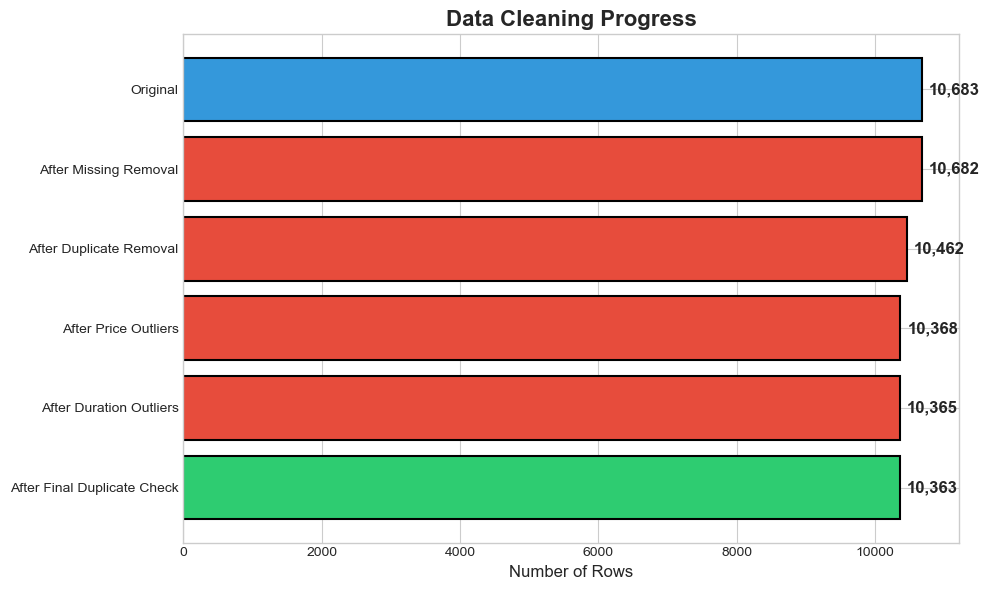

In [75]:
# Cleaning log visualization
fig, ax = plt.subplots(figsize=(10, 6))

stages = list(cleaning_log.keys())
counts = list(cleaning_log.values())

colors = ['#3498db'] + ['#e74c3c'] * (len(stages) - 1)
colors[-1] = '#2ecc71'  # Final count in green

bars = ax.barh(stages, counts, color=colors, edgecolor='black', linewidth=1.5)

for bar, count in zip(bars, counts):
    ax.text(count + 100, bar.get_y() + bar.get_height()/2., 
            f'{count:,}', va='center', fontsize=12, fontweight='bold')

ax.set_title('Data Cleaning Progress', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Rows', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [76]:
# Print summary
print("CLEANING SUMMARY")
print("="*50)
print(f"Original rows: {cleaning_log['Original']:,}")
print(f"Final rows: {len(df):,}")
print(f"Total removed: {cleaning_log['Original'] - len(df):,} ({(cleaning_log['Original'] - len(df))/cleaning_log['Original']*100:.1f}%)")
print("\nBreakdown:")

prev = cleaning_log['Original']
for stage, count in cleaning_log.items():
    if stage != 'Original':
        removed = prev - count
        print(f"  {stage}: -{removed:,} rows")
        prev = count

CLEANING SUMMARY
Original rows: 10,683
Final rows: 10,363
Total removed: 320 (3.0%)

Breakdown:
  After Missing Removal: -1 rows
  After Duplicate Removal: -220 rows
  After Price Outliers: -94 rows
  After Duration Outliers: -3 rows
  After Final Duplicate Check: -2 rows


---
## 2.12 Save Cleaned Data

In [77]:
df.to_csv('D:/Courses/DL INTERNSHIP/SECOND PROJECT/project_structure/data/processed/flight_data_cleaned.csv', index=False)
print("Cleaned data saved to 'flight_data_cleaned.csv'")

Cleaned data saved to 'flight_data_cleaned.csv'


---
## 2.13 Phase 2 Summary (Upload This Output)

In [78]:
print("="*70)
print("PHASE 2: DATA CLEANING SUMMARY")
print("="*70)

print("\n1. MISSING VALUES")
print(f"   Rows removed: {cleaning_log['Original'] - cleaning_log['After Missing Removal']}")

print("\n2. DUPLICATES")
print(f"   Rows removed: {cleaning_log['After Missing Removal'] - cleaning_log['After Duplicate Removal']}")

print("\n3. PRICE OUTLIERS (IQR Method)")
print(f"   Lower bound: ₹{lower_bound_price:,.0f}")
print(f"   Upper bound: ₹{upper_bound_price:,.0f}")
print(f"   Rows removed: {cleaning_log['After Duplicate Removal'] - cleaning_log['After Price Outliers']}")

print("\n4. DURATION OUTLIERS (Logical Validation)")
print("   Minimum duration thresholds by stops:")
for stops, min_dur in MIN_DURATION_BY_STOPS.items():
    print(f"     {stops} stops: {min_dur} min ({min_dur/60:.1f} hours)")
print(f"   Rows removed: {cleaning_log['After Price Outliers'] - cleaning_log['After Duration Outliers']}")

print("\n5. FINAL DUPLICATE CHECK")
print(f"   Rows removed: {cleaning_log['After Duration Outliers'] - cleaning_log['After Final Duplicate Check']}")

print("\n6. FEATURES ENGINEERED")
print("   - Duration_Minutes (from Duration)")
print("   - Stops (from Total_Stops)")
print("   - Journey_Day, Journey_Month, Journey_Day_of_Week")
print("   - Dep_Hour, Dep_Minute")
print("   - Arrival_Hour, Arrival_Minute")
print("   - Route_Pair")

print("\n7. FINAL DATASET")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")
print(f"   Columns: {df.columns.tolist()}")

print("\n8. DATA QUALITY")
print(f"   Missing values: {df.isnull().sum().sum()}")
print(f"   Duplicates: {df.duplicated().sum()}")
print(f"   Price range: ₹{df['Price'].min():,} - ₹{df['Price'].max():,}")
print(f"   Duration range: {df['Duration_Minutes'].min()} - {df['Duration_Minutes'].max()} min")

print("\n9. DURATION VALIDATION BY STOPS")
for stops in sorted(df['Stops'].unique()):
    subset = df[df['Stops'] == stops]
    print(f"   {stops} stops: {subset['Duration_Minutes'].min()}-{subset['Duration_Minutes'].max()} min (n={len(subset)})")

print("\n10. SAVED FILES")
print("   - flight_data_cleaned.xlsx")
print("   - flight_data_cleaned.csv")



PHASE 2: DATA CLEANING SUMMARY

1. MISSING VALUES
   Rows removed: 1

2. DUPLICATES
   Rows removed: 220

3. PRICE OUTLIERS (IQR Method)
   Lower bound: ₹-5,457
   Upper bound: ₹23,026
   Rows removed: 94

4. DURATION OUTLIERS (Logical Validation)
   Minimum duration thresholds by stops:
     0 stops: 30 min (0.5 hours)
     1 stops: 120 min (2.0 hours)
     2 stops: 240 min (4.0 hours)
     3 stops: 360 min (6.0 hours)
     4 stops: 480 min (8.0 hours)
   Rows removed: 3

5. FINAL DUPLICATE CHECK
   Rows removed: 2

6. FEATURES ENGINEERED
   - Duration_Minutes (from Duration)
   - Stops (from Total_Stops)
   - Journey_Day, Journey_Month, Journey_Day_of_Week
   - Dep_Hour, Dep_Minute
   - Arrival_Hour, Arrival_Minute
   - Route_Pair

7. FINAL DATASET
   Rows: 10,363
   Columns: 15
   Columns: ['Airline', 'Source', 'Destination', 'Additional_Info', 'Price', 'Duration_Minutes', 'Stops', 'Journey_Day', 'Journey_Month', 'Journey_Day_of_Week', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Arri